In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np

PROJECT_PATH = "/".join(os.getcwd().split('/')[:-1])
DATA_PATH = os.path.join(PROJECT_PATH, 'data')
TRAIN_DATA_PATH = os.path.join(DATA_PATH, 'train.csv')

# Load the training dataset
house_prices_train = pd.read_csv(TRAIN_DATA_PATH)
house_prices_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [2]:
# Remove the ID field
house_prices_train = house_prices_train.drop('Id', axis=1)

In [3]:
house_prices_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

## Understanding the target variable

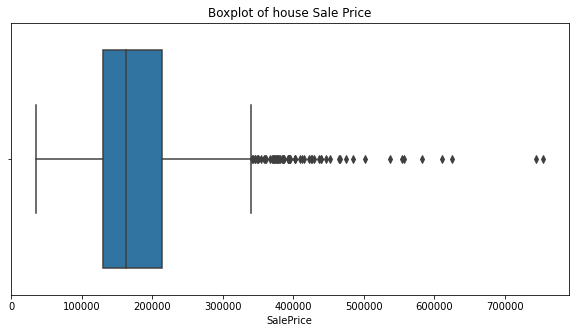

In [4]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

sale_price = house_prices_train['SalePrice']

plt.figure(figsize=(10, 5))
sns.boxplot(sale_price)
plt.title('Boxplot of house Sale Price')
plt.show()

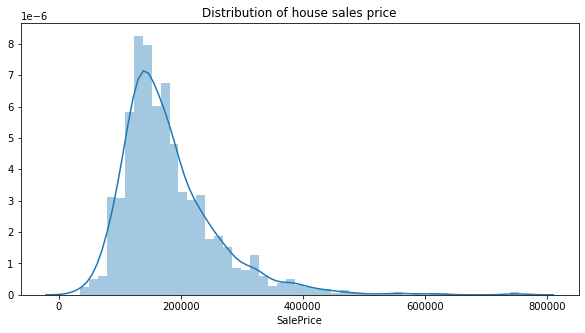

In [5]:
plt.figure(figsize=(10, 5))
sns.distplot(sale_price)
plt.title('Distribution of house sales price')
plt.show()

From the distribution of the data, the average house price is around 180,000 dollers. Anything past 340,000 dollers is considered a really expensive house so we will typically see less of them. 

## Finding the best features for analysis

In [6]:
target_col = 'SalePrice'

test_size_ratio = 0.2
val_size_ratio = 0.1

X = house_prices_train.drop(target_col, axis=1)
y = house_prices_train[target_col]

In [7]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin

def get_cols_by_types(types):
    return X.select_dtypes(include=types).columns.tolist()

class FeatureExtractor(TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.cols]

# Extract the cols
numeric_cols = get_cols_by_types(['float64', 'int64'])
cat_cols = get_cols_by_types(['object'])

In [8]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

numeric_pipeline = Pipeline([
    ('extractor', FeatureExtractor(numeric_cols)),
    ('impute', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

cat_pipeline = Pipeline([
    ('extractor', FeatureExtractor(cat_cols)),
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one_hot', OneHotEncoder(handle_unknown='ignore'))
])

processing_pipeline = FeatureUnion([
    ('numeric', numeric_pipeline),
    ('categorical', cat_pipeline)
])

In [9]:
X_processed = processing_pipeline.fit_transform(X)

In [10]:
from sklearn.feature_selection import chi2, SelectKBest

best_features = SelectKBest(score_func=chi2, k=20)
best_features.fit(X_processed, y)

SelectKBest(k=20, score_func=<function chi2 at 0x121ca8400>)

In [11]:
categorical_features = np.concatenate(cat_pipeline['one_hot'].categories_)
all_features = np.concatenate([numeric_cols, categorical_features])

best_scores_df = pd.DataFrame()
best_scores_df['feature'] = all_features
best_scores_df['scores'] = best_features.scores_
best_scores_df.head()

,feature,scores
0,MSSubClass,174.897301
1,LotFrontage,24.778633
2,LotArea,53.946815
3,OverallQual,50.246718
4,OverallCond,23.606408


In [12]:
top_20_features_df = best_scores_df.nlargest(20, 'scores')
best_features_index = top_20_features_df.index.tolist()
best_features_index

[139,
 174,
 156,
 103,
 206,
 275,
 284,
 167,
 235,
 101,
 188,
 279,
 79,
 287,
 78,
 36,
 224,
 182,
 87,
 47]

In [13]:
X_best_features = X_processed.toarray()[:, best_features_index]

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_best_features, y, random_state=42, test_size=test_size_ratio)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=val_size_ratio)

print('Train: ', X_train.shape)
print('Val: ', X_val.shape)
print('Test: ', X_test.shape)

Train:  (1051, 20)
Val:  (117, 20)
Test:  (292, 20)


In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

rf_reg = RandomForestRegressor(random_state=42)
scores = cross_val_score(rf_reg, X_train, y_train, cv=3, scoring='neg_mean_squared_error')

In [16]:
np.sqrt(-scores)

array([57342.95115922, 56498.25421009, 53116.22219712])

In [17]:
X_numeric = numeric_pipeline.transform(X)
best_numeric_features = SelectKBest(score_func=chi2, k=20)
best_numeric_features.fit(X_numeric, y)

SelectKBest(k=20, score_func=<function chi2 at 0x121ca8400>)

In [18]:
best_numeric_scores_df = pd.DataFrame()
best_numeric_scores_df['feature'] = numeric_cols
best_numeric_scores_df['scores'] = best_numeric_features.scores_
best_numeric_scores_df.head()

,feature,scores
0,MSSubClass,174.897301
1,LotFrontage,24.778633
2,LotArea,53.946815
3,OverallQual,50.246718
4,OverallCond,23.606408


In [19]:
best_20_numeric_scores = best_numeric_scores_df.nlargest(20, 'scores')
best_20_numeric_scores = best_20_numeric_scores.index.tolist()
best_20_numeric_scores

[32, 14, 33, 30, 17, 31, 19, 9, 13, 23, 6, 29, 7, 0, 35, 27, 16, 28, 10, 25]

In [20]:
X_best_features = X_processed.toarray()[:, best_20_numeric_scores]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_best_features, y, random_state=42, test_size=test_size_ratio)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=val_size_ratio)

print('Train: ', X_train.shape)
print('Val: ', X_val.shape)
print('Test: ', X_test.shape)

Train:  (1051, 20)
Val:  (117, 20)
Test:  (292, 20)


In [28]:
rf_reg = RandomForestRegressor(random_state=42)
scores = cross_val_score(rf_reg, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
scores

array([-1.83646129e+09, -1.65016337e+09, -1.31251150e+09])

In [29]:
np.sqrt(-scores)

array([42853.95300384, 40622.20287653, 36228.6005154 ])

In [30]:
np.sqrt(-scores).mean()

39901.58546525869

On average, the error between values was 39901 dollers. This is quite a large difference between the predicted values.

## Looking at the numeric values

In [59]:
X_numeric_processes = numeric_pipeline.transform(X)
X_numeric_processes

array([[0.23529412, 0.15068493, 0.0334198 , ..., 0.        , 0.09090909,
        0.5       ],
       [0.        , 0.20205479, 0.03879502, ..., 0.        , 0.36363636,
        0.25      ],
       [0.23529412, 0.1609589 , 0.04650728, ..., 0.        , 0.72727273,
        0.5       ],
       ...,
       [0.29411765, 0.15410959, 0.03618687, ..., 0.16129032, 0.36363636,
        1.        ],
       [0.        , 0.1609589 , 0.03934189, ..., 0.        , 0.27272727,
        1.        ],
       [0.        , 0.18493151, 0.04037019, ..., 0.        , 0.45454545,
        0.5       ]])

In [60]:
numeric_best_features = SelectKBest(score_func=chi2, k=20)
numeric_best_features.fit(X_numeric_processes, y)

SelectKBest(k=20, score_func=<function chi2 at 0x121ca8400>)

In [66]:
X_numeric_best = X_numeric_processes[:, numeric_best_features.get_support()]

X_train, X_test, y_train, y_test = train_test_split(X_numeric_best, y, random_state=42, test_size=test_size_ratio)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=val_size_ratio)

print('Train: ', X_train.shape)
print('Val: ', X_val.shape)
print('Test: ', X_test.shape)

Train:  (1051, 20)
Val:  (117, 20)
Test:  (292, 20)


In [67]:
rf_reg = RandomForestRegressor(random_state=42)
scores = cross_val_score(rf_reg, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
scores

array([-1.85570604e+09, -1.68056594e+09, -1.28675108e+09])

In [68]:
np.sqrt(-scores)

array([43077.9066579 , 40994.70622836, 35871.31270922])

In [69]:
np.sqrt(-scores).mean()

39981.308531827344

In [70]:
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [74]:
sorted(rf_reg.feature_importances_)[::-1]

[0.4744145377006707,
 0.12252437806585645,
 0.07129351363638536,
 0.06500087328298136,
 0.048269768810397566,
 0.0440450768154414,
 0.04252338049455929,
 0.030034887965485382,
 0.02262035133800515,
 0.01921228705991398,
 0.017986476031935348,
 0.010267667902227077,
 0.0075265805313708325,
 0.00708814132982872,
 0.0070305473454721065,
 0.00400844708756829,
 0.0018907577239004462,
 0.0017530820659318715,
 0.0016672378691222434,
 0.0008420069429463709]

In [97]:
numeric_col_indexes = np.where(numeric_best_features.get_support())[0].tolist()
important_numeric_cols = [(numeric_cols[x], s) for x, s in zip(numeric_col_indexes, rf_reg.feature_importances_)]
important_numeric_cols

[('MSSubClass', 0.02262035133800515),
 ('YearRemodAdd', 0.12252437806585645),
 ('MasVnrArea', 0.0440450768154414),
 ('BsmtFinSF2', 0.00708814132982872),
 ('BsmtUnfSF', 0.048269768810397566),
 ('2ndFlrSF', 0.07129351363638536),
 ('LowQualFinSF', 0.0008420069429463709),
 ('BsmtFullBath', 0.01921228705991398),
 ('BsmtHalfBath', 0.0016672378691222434),
 ('HalfBath', 0.00400844708756829),
 ('Fireplaces', 0.06500087328298136),
 ('GarageCars', 0.4744145377006707),
 ('WoodDeckSF', 0.030034887965485382),
 ('OpenPorchSF', 0.04252338049455929),
 ('EnclosedPorch', 0.0070305473454721065),
 ('3SsnPorch', 0.0017530820659318715),
 ('ScreenPorch', 0.017986476031935348),
 ('PoolArea', 0.0075265805313708325),
 ('MiscVal', 0.0018907577239004462),
 ('YrSold', 0.010267667902227077)]

In [102]:
sorted_important_num_features = sorted(important_numeric_cols, key=lambda x: x[1])[::-1]
sorted_important_num_features

[('GarageCars', 0.4744145377006707),
 ('YearRemodAdd', 0.12252437806585645),
 ('2ndFlrSF', 0.07129351363638536),
 ('Fireplaces', 0.06500087328298136),
 ('BsmtUnfSF', 0.048269768810397566),
 ('MasVnrArea', 0.0440450768154414),
 ('OpenPorchSF', 0.04252338049455929),
 ('WoodDeckSF', 0.030034887965485382),
 ('MSSubClass', 0.02262035133800515),
 ('BsmtFullBath', 0.01921228705991398),
 ('ScreenPorch', 0.017986476031935348),
 ('YrSold', 0.010267667902227077),
 ('PoolArea', 0.0075265805313708325),
 ('BsmtFinSF2', 0.00708814132982872),
 ('EnclosedPorch', 0.0070305473454721065),
 ('HalfBath', 0.00400844708756829),
 ('MiscVal', 0.0018907577239004462),
 ('3SsnPorch', 0.0017530820659318715),
 ('BsmtHalfBath', 0.0016672378691222434),
 ('LowQualFinSF', 0.0008420069429463709)]

In [122]:
b = [[idx, z] for idx, z in enumerate(important_numeric_cols)]
b

[[0, ('MSSubClass', 0.02262035133800515)],
 [1, ('YearRemodAdd', 0.12252437806585645)],
 [2, ('MasVnrArea', 0.0440450768154414)],
 [3, ('BsmtFinSF2', 0.00708814132982872)],
 [4, ('BsmtUnfSF', 0.048269768810397566)],
 [5, ('2ndFlrSF', 0.07129351363638536)],
 [6, ('LowQualFinSF', 0.0008420069429463709)],
 [7, ('BsmtFullBath', 0.01921228705991398)],
 [8, ('BsmtHalfBath', 0.0016672378691222434)],
 [9, ('HalfBath', 0.00400844708756829)],
 [10, ('Fireplaces', 0.06500087328298136)],
 [11, ('GarageCars', 0.4744145377006707)],
 [12, ('WoodDeckSF', 0.030034887965485382)],
 [13, ('OpenPorchSF', 0.04252338049455929)],
 [14, ('EnclosedPorch', 0.0070305473454721065)],
 [15, ('3SsnPorch', 0.0017530820659318715)],
 [16, ('ScreenPorch', 0.017986476031935348)],
 [17, ('PoolArea', 0.0075265805313708325)],
 [18, ('MiscVal', 0.0018907577239004462)],
 [19, ('YrSold', 0.010267667902227077)]]

## Misc

**Will come back to this stuff**

In [24]:
# cols = house_prices_train.columns
# cols_to_remove = []
# print('Features with over 80% of features missing:')
# for c in cols:
#     col_data = house_prices_train[c]
#     missing = col_data[col_data.isna()]
#     missing_ratio = (len(missing) / len(col_data))
#     if missing_ratio > 0.8:
#         cols_to_remove.append(c)
#         print('{}: {:.2f}%'.format(c, missing_ratio * 100))

In [25]:
# # Extract the relevant cols
# interested_cols = [c for c in cols if c not in cols_to_remove]

# # Create a copy of the dataset with the cols
# train_data_refined = house_prices_train[interested_cols].copy()

In [26]:
# corr = train_data_refined.corr()
# mask = np.triu(np.ones_like(corr, dtype=np.bool))

# plt.figure(figsize=(10, 10))
# sns.heatmap(corr, mask=mask)
# plt.show()